# Standard U-Net: Baseline Model for Tumor Segmentation + Classification

This notebook implements a **single, standard U-Net** with dual outputs (segmentation + classification) as a baseline to compare against Co-DeepNet.

## Goal: Prove Co-DeepNet's Superiority

According to the research paper, **two smaller cooperative networks should outperform one larger network**:
- Better accuracy with less computational cost
- More efficient exploration of solution space
- Better generalization through network diversity

This baseline will help us verify these claims!

## Architecture Overview:
```
Input → [Single U-Net] → {Classification, Segmentation}
```

vs Co-DeepNet:
```
Input → [U-Net-A] ⟷ Knowledge Transfer ⟷ [U-Net-B] → Ensemble → {Classification, Segmentation}
```

## 1. Setup & Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from typing import Tuple, Dict, List
from PIL import Image

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.7.1+cu118


## 2. Standard U-Net Architecture with Dual Output

Same architecture as Co-DeepNet's individual networks, but trained as a single model.

In [2]:
class DoubleConv(nn.Module):
    """(Conv2d → BatchNorm → ReLU) × 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class SegmentationUNet(nn.Module):
    """
    Standard U-Net for SEGMENTATION ONLY.
    Classification is derived from the segmentation mask.
    """
    def __init__(self, in_channels=1, seg_classes=1):
        super().__init__()
        
        # Encoder (Contracting Path)
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)
        
        # Decoder (Expanding Path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        
        # Segmentation
        self.seg_out = nn.Conv2d(64, seg_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)
        
        # Segmentation Output
        seg_logits = self.seg_out(dec1)
        
        return seg_logits
    
    def count_parameters(self):
        """Count total trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class BCEDiceLoss(nn.Module):
    """BCE + Dice Loss for binary segmentation (num_classes = 1)"""
    def __init__(self, smooth=1.0, bce_weight=0.5):
        """
        smooth: stabilizer to avoid division by zero
        bce_weight: balance between BCE and Dice (0–1)
        """
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.smooth = smooth
        self.bce_weight = bce_weight

    def forward(self, logits, target):
        # BCEWithLogitsLoss expects raw logits (no sigmoid)
        bce = self.bce(logits, target)

        # Dice part
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        target = target.view(-1)
        intersection = (probs * target).sum()
        dice = (2.0 * intersection + self.smooth) / (probs.sum() + target.sum() + self.smooth)
        dice_loss = 1 - dice

        # Weighted sum
        return self.bce_weight * bce + (1 - self.bce_weight) * dice_loss


# Initialize model
unet_model = SegmentationUNet(in_channels=1, seg_classes=1).to(device)
num_params = unet_model.count_parameters()

print(f"\n✓ Segmentation-Only U-Net initialized")
print(f"  Total parameters: {num_params:,}")
print(f"  Model size: ~{num_params * 4 / 1024 / 1024:.2f} MB (fp32)")
print(f"  Architecture: Segmentation")


✓ Segmentation-Only U-Net initialized
  Total parameters: 31,042,369
  Model size: ~118.42 MB (fp32)
  Architecture: Segmentation


## 3. Dataset Loading (Pre-Split)

Loading pre-split train/val/test data from EDA.ipynb preprocessing.

In [3]:
class PreSplitTumorDataset(Dataset):
    """Dataset for loading pre-split train/val/test data"""
    def __init__(self, data_dir: str, split='train'):
        """
        Args:
            data_dir: Path to preprocessed_data directory
            split: 'train', 'val', or 'test'
        """
        self.data_dir = Path(data_dir) / split
        self.split = split
        
        print(f"\n{'='*70}")
        print(f"📂 Loading {split.upper()} dataset from: {self.data_dir}")
        print(f"{'='*70}")
        
        if not self.data_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {self.data_dir}")
        
        self.samples = []
        
        control_dir = self.data_dir / 'controls' / 'imgs'
        patient_img_dir = self.data_dir / 'patients' / 'imgs'
        patient_label_dir = self.data_dir / 'patients' / 'labels'
        
        print(f"  Controls dir: {control_dir.exists()}")
        print(f"  Patients dir: {patient_img_dir.exists()}")
        print(f"  Labels dir: {patient_label_dir.exists()}")
        
        if control_dir.exists():
            control_files = sorted(list(control_dir.glob('*.png')))
            print(f"\n  Found {len(control_files)} control images")
            for img_path in control_files:
                self.samples.append((img_path, None, 0))
        
        if patient_img_dir.exists() and patient_label_dir.exists():
            patient_files = sorted(list(patient_img_dir.glob('*.png')))
            print(f"  Found {len(patient_files)} patient images")
            
            matched = 0
            for img_path in patient_files:
                img_stem = img_path.stem
                
                possible_label_names = [
                    img_path.name,
                    img_stem + '.png',
                    img_stem.replace('patient_', 'segmentation_') + '.png',
                ]
                
                label_path = None
                for label_name in possible_label_names:
                    test_path = patient_label_dir / label_name
                    if test_path.exists():
                        label_path = test_path
                        break
                
                if label_path:
                    self.samples.append((img_path, label_path, 1))
                    matched += 1
            
            print(f"  Matched {matched} patient images with labels")
        
        num_controls = len([s for s in self.samples if s[2] == 0])
        num_patients = len([s for s in self.samples if s[2] == 1])
        
        print(f"\n{'='*70}")
        print(f"📊 {split.upper()} SET SUMMARY")
        print(f"{'='*70}")
        print(f"  Controls: {num_controls}")
        print(f"  Patients: {num_patients}")
        print(f"  Total: {len(self.samples)}")
        print(f"  Tumor ratio: {num_patients/len(self.samples)*100:.1f}%")
        print(f"{'='*70}\n")
        
        if len(self.samples) == 0:
            raise ValueError(f"No samples found in {self.data_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def _load_image(self, path: Path) -> np.ndarray:
        """Load PNG image and convert to grayscale numpy array"""
        img = Image.open(path).convert('L')
        return np.array(img)
    
    def __getitem__(self, idx):
        img_path, label_path, has_tumor = self.samples[idx]
        
        image = self._load_image(img_path)
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if label_path and label_path.exists():
            mask = self._load_image(label_path)
            if mask.max() > 1.0:
                mask = mask / 255.0
        else:
            mask = np.zeros_like(image)
        
        if image.ndim == 2:
            image = image[np.newaxis, ...]
        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]
        
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()
        clf_label = torch.tensor(has_tumor, dtype=torch.long)
        
        return image, mask, clf_label


print("="*70)
print("🔍 LOADING PRE-SPLIT MIP-PET TUMOR DATASET")
print("="*70)

possible_paths = [
    Path('/Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/preprocessed_data'),
    Path('/work/IdaHayJørgensen#9284/Notebooks/preprocessed_data'),
]

DATA_DIR = None
for path in possible_paths:
    print(f"\n🔍 Checking: {path}")
    if path.exists():
        has_train = (path / 'train').exists()
        has_val = (path / 'val').exists()
        has_test = (path / 'test').exists()
        
        print(f"   Train folder: {has_train}")
        print(f"   Val folder: {has_val}")
        print(f"   Test folder: {has_test}")
        
        if has_train and has_val and has_test:
            DATA_DIR = path
            print(f"   ✅ Using this directory!")
            break
    else:
        print(f"   ❌ Directory doesn't exist")

if DATA_DIR is None:
    raise FileNotFoundError("Pre-split data directory not found! Please run EDA.ipynb first to create splits.")

print(f"\n{'='*70}")
print(f"📂 Final data directory: {DATA_DIR}")
print(f"{'='*70}\n")

train_dataset = PreSplitTumorDataset(str(DATA_DIR), split='train')
val_dataset = PreSplitTumorDataset(str(DATA_DIR), split='val')
test_dataset = PreSplitTumorDataset(str(DATA_DIR), split='test')

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n{'='*70}")
print(f"✅ DATALOADERS CREATED")
print(f"{'='*70}")
print(f"  Train batches: {len(train_loader)} ({len(train_dataset)} samples)")
print(f"  Val batches: {len(val_loader)} ({len(val_dataset)} samples)")
print(f"  Test batches: {len(test_loader)} ({len(test_dataset)} samples)")
print(f"{'='*70}\n")


🔍 LOADING PRE-SPLIT MIP-PET TUMOR DATASET

🔍 Checking: /Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/preprocessed_data
   ❌ Directory doesn't exist

🔍 Checking: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data
   Train folder: True
   Val folder: True
   Test folder: True
   ✅ Using this directory!

📂 Final data directory: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data


📂 Loading TRAIN dataset from: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data/train
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 298 control images
  Found 127 patient images
  Matched 127 patient images with labels

📊 TRAIN SET SUMMARY
  Controls: 298
  Patients: 127
  Total: 425
  Tumor ratio: 29.9%


📂 Loading VAL dataset from: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data/val
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 64 control images
  Found 27 patient images
  Matched 27 patient images with labels

📊 VA

## 4. Training Setup

In [4]:
# Training configuration
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4

# Optimizer
optimizer = torch.optim.Adam(unet_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Loss function: Combined BCE + Dice Loss for segmentation
seg_criterion = BCEDiceLoss(smooth=1.0, bce_weight=0.5)

# Training history
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'epoch_times': []
}

print("✓ Training configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Loss: Combined BCE + Dice Loss")
print(f"  Metrics: Dice, IoU, BCE")
print(f"  Optimizer: Adam with weight decay={1e-5}")

✓ Training configuration:
  Epochs: 50
  Learning rate: 0.0001
  Loss: Combined BCE + Dice Loss
  Metrics: Dice, IoU, BCE
  Optimizer: Adam with weight decay=1e-05


## Training Loop with Validation

In [5]:
import time

def dice_coefficient(pred, target, threshold=0.5, epsilon=1e-7):
    """Compute Dice coefficient"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum()
    
    dice = (2.0 * intersection) / (union + epsilon)
    return dice.item()


def iou_score(pred, target, threshold=0.5, epsilon=1e-7):
    """Compute IoU (Intersection over Union)"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection
    
    iou = intersection / (union + epsilon)
    return iou.item()


def train_epoch(model, dataloader, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    epoch_loss = []
    epoch_dice = []
    epoch_iou = []
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Train]")
    for images, masks, _ in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        seg_logits = model(images)
        
        # Compute loss
        loss = seg_criterion(seg_logits, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Compute metrics
        seg_probs = torch.sigmoid(seg_logits)
        dice = dice_coefficient(seg_probs, masks)
        iou = iou_score(seg_probs, masks)
        
        # Track metrics
        epoch_loss.append(loss.item())
        epoch_dice.append(dice)
        epoch_iou.append(iou)
        
        # Update progress
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'dice': f"{dice:.4f}",
            'iou': f"{iou:.4f}"
        })
    
    return {
        'loss': np.mean(epoch_loss),
        'dice': np.mean(epoch_dice),
        'iou': np.mean(epoch_iou)
    }


def validate_epoch(model, dataloader, epoch):
    """Validate for one epoch"""
    model.eval()
    epoch_loss = []
    epoch_dice = []
    epoch_iou = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Val]")
        for images, masks, _ in pbar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            seg_logits = model(images)
            loss = seg_criterion(seg_logits, masks)
            
            # Compute metrics
            seg_probs = torch.sigmoid(seg_logits)
            dice = dice_coefficient(seg_probs, masks)
            iou = iou_score(seg_probs, masks)
            
            # Track metrics
            epoch_loss.append(loss.item())
            epoch_dice.append(dice)
            epoch_iou.append(iou)
            
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'dice': f"{dice:.4f}",
                'iou': f"{iou:.4f}"
            })
    
    return {
        'loss': np.mean(epoch_loss),
        'dice': np.mean(epoch_dice),
        'iou': np.mean(epoch_iou)
    }


print("\n" + "="*70)
print("🚀 STARTING TRAINING (Segmentation-Only U-Net)")
print("="*70)
print("Stage 1: Segmentation Training")
print("Stage 2: Classification from Masks\n")

training_start = time.time()
best_val_dice = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()
    
    # Train
    train_metrics = train_epoch(unet_model, train_loader, optimizer, epoch)
    
    # Validate
    val_metrics = validate_epoch(unet_model, val_loader, epoch)
    
    # Track history
    history['train_loss'].append(train_metrics['loss'])
    history['train_dice'].append(train_metrics['dice'])
    history['train_iou'].append(train_metrics['iou'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_dice'].append(val_metrics['dice'])
    history['val_iou'].append(val_metrics['iou'])
    
    epoch_time = time.time() - epoch_start
    history['epoch_times'].append(epoch_time)
    
    # Print summary
    print(f"\nEpoch {epoch}/{NUM_EPOCHS} Summary:")
    print(f"  Train - Loss: {train_metrics['loss']:.4f}, Dice: {train_metrics['dice']:.4f}, IoU: {train_metrics['iou']:.4f}")
    print(f"  Val   - Loss: {val_metrics['loss']:.4f}, Dice: {val_metrics['dice']:.4f}, IoU: {val_metrics['iou']:.4f}")
    print(f"  Time: {epoch_time:.1f}s")
    
    # Save best model
    if val_metrics['dice'] > best_val_dice:
        best_val_dice = val_metrics['dice']
        torch.save(unet_model.state_dict(), 'best_unet_segmentation.pth')
        print(f"  ✓ New best model saved! (Dice: {best_val_dice:.4f})")

training_time = time.time() - training_start

print("\n" + "="*70)
print("🎓 SEGMENTATION TRAINING COMPLETE!")
print("="*70)
print(f"Total training time: {training_time:.1f}s ({training_time/60:.1f} minutes)")
print(f"Average epoch time: {np.mean(history['epoch_times']):.1f}s")
print(f"Best validation Dice: {best_val_dice:.4f}")

# Load best model
unet_model.load_state_dict(torch.load('best_unet_segmentation.pth'))
print("\n✓ Best model loaded for evaluation!")


🚀 STARTING TRAINING (Segmentation-Only U-Net)
Stage 1: Segmentation Training
Stage 2: Classification from Masks



Epoch 1 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.47it/s, loss=0.6928, dice=0.1111, iou=0.0588]



Epoch 1/50 Summary:
  Train - Loss: 0.7598, Dice: 0.0591, IoU: 0.0317
  Val   - Loss: 0.7050, Dice: 0.0520, IoU: 0.0290
  Time: 14.3s
  ✓ New best model saved! (Dice: 0.0520)


Epoch 2 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.24it/s, loss=0.6669, dice=0.2718, iou=0.1573]



Epoch 2/50 Summary:
  Train - Loss: 0.6876, Dice: 0.1916, IoU: 0.1154
  Val   - Loss: 0.6724, Dice: 0.1176, IoU: 0.0721
  Time: 13.9s
  ✓ New best model saved! (Dice: 0.1176)


Epoch 3 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.48it/s, loss=0.6422, dice=0.2226, iou=0.1253]



Epoch 3/50 Summary:
  Train - Loss: 0.6641, Dice: 0.2715, IoU: 0.1741
  Val   - Loss: 0.6477, Dice: 0.0212, IoU: 0.0118
  Time: 14.0s


Epoch 4 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.00it/s, loss=0.6214, dice=0.2316, iou=0.1310]



Epoch 4/50 Summary:
  Train - Loss: 0.6481, Dice: 0.2700, IoU: 0.1741
  Val   - Loss: 0.6318, Dice: 0.0907, IoU: 0.0558
  Time: 14.1s


Epoch 5 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.46it/s, loss=0.6265, dice=0.1714, iou=0.0937]



Epoch 5/50 Summary:
  Train - Loss: 0.6326, Dice: 0.2935, IoU: 0.1979
  Val   - Loss: 0.6236, Dice: 0.0959, IoU: 0.0574
  Time: 14.1s


Epoch 6 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.71it/s, loss=0.6385, dice=0.2627, iou=0.1512]



Epoch 6/50 Summary:
  Train - Loss: 0.6201, Dice: 0.3149, IoU: 0.2093
  Val   - Loss: 0.6440, Dice: 0.1021, IoU: 0.0608
  Time: 14.2s


Epoch 7 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.30it/s, loss=0.5990, dice=0.3503, iou=0.2123]



Epoch 7/50 Summary:
  Train - Loss: 0.6071, Dice: 0.3613, IoU: 0.2478
  Val   - Loss: 0.6071, Dice: 0.1497, IoU: 0.0983
  Time: 14.1s
  ✓ New best model saved! (Dice: 0.1497)


Epoch 8 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.35it/s, loss=0.6014, dice=0.3358, iou=0.2018]



Epoch 8/50 Summary:
  Train - Loss: 0.5966, Dice: 0.3633, IoU: 0.2552
  Val   - Loss: 0.5968, Dice: 0.1449, IoU: 0.0938
  Time: 14.1s


Epoch 9 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.13it/s, loss=0.5680, dice=0.4359, iou=0.2787]



Epoch 9/50 Summary:
  Train - Loss: 0.5918, Dice: 0.3123, IoU: 0.2097
  Val   - Loss: 0.5814, Dice: 0.1663, IoU: 0.1118
  Time: 14.2s
  ✓ New best model saved! (Dice: 0.1663)


Epoch 10 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.64it/s, loss=0.5892, dice=0.3031, iou=0.1786]



Epoch 10/50 Summary:
  Train - Loss: 0.5772, Dice: 0.3906, IoU: 0.2720
  Val   - Loss: 0.5826, Dice: 0.1484, IoU: 0.0981
  Time: 14.1s


Epoch 11 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.25it/s, loss=0.5479, dice=0.3794, iou=0.2341]



Epoch 11/50 Summary:
  Train - Loss: 0.5693, Dice: 0.3618, IoU: 0.2516
  Val   - Loss: 0.5654, Dice: 0.1569, IoU: 0.1045
  Time: 14.0s


Epoch 12 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.63it/s, loss=0.5353, dice=0.4343, iou=0.2774]



Epoch 12/50 Summary:
  Train - Loss: 0.5612, Dice: 0.3884, IoU: 0.2736
  Val   - Loss: 0.5606, Dice: 0.1553, IoU: 0.1022
  Time: 14.1s


Epoch 13 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.55it/s, loss=0.5269, dice=0.4566, iou=0.2958]



Epoch 13/50 Summary:
  Train - Loss: 0.5518, Dice: 0.4035, IoU: 0.2843
  Val   - Loss: 0.5499, Dice: 0.1717, IoU: 0.1164
  Time: 14.0s
  ✓ New best model saved! (Dice: 0.1717)


Epoch 14 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.89it/s, loss=0.5481, dice=0.3305, iou=0.1980]



Epoch 14/50 Summary:
  Train - Loss: 0.5456, Dice: 0.4346, IoU: 0.3104
  Val   - Loss: 0.5648, Dice: 0.1311, IoU: 0.0828
  Time: 14.4s


Epoch 15 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.83it/s, loss=0.5129, dice=0.4875, iou=0.3223]



Epoch 15/50 Summary:
  Train - Loss: 0.5380, Dice: 0.3880, IoU: 0.2737
  Val   - Loss: 0.5395, Dice: 0.1856, IoU: 0.1301
  Time: 14.2s
  ✓ New best model saved! (Dice: 0.1856)


Epoch 16 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.93it/s, loss=0.5053, dice=0.4236, iou=0.2687]



Epoch 16/50 Summary:
  Train - Loss: 0.5290, Dice: 0.4502, IoU: 0.3228
  Val   - Loss: 0.5351, Dice: 0.1652, IoU: 0.1116
  Time: 14.0s


Epoch 17 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.23it/s, loss=0.4849, dice=0.4508, iou=0.2910]



Epoch 17/50 Summary:
  Train - Loss: 0.5249, Dice: 0.4068, IoU: 0.2898
  Val   - Loss: 0.5183, Dice: 0.1685, IoU: 0.1143
  Time: 14.0s


Epoch 18 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.98it/s, loss=0.5036, dice=0.3618, iou=0.2209]



Epoch 18/50 Summary:
  Train - Loss: 0.5160, Dice: 0.4616, IoU: 0.3364
  Val   - Loss: 0.5239, Dice: 0.1593, IoU: 0.1076
  Time: 14.1s


Epoch 19 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.14it/s, loss=0.4675, dice=0.5123, iou=0.3444]



Epoch 19/50 Summary:
  Train - Loss: 0.5094, Dice: 0.4606, IoU: 0.3354
  Val   - Loss: 0.5111, Dice: 0.1982, IoU: 0.1428
  Time: 14.2s
  ✓ New best model saved! (Dice: 0.1982)


Epoch 20 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.99it/s, loss=0.4849, dice=0.4036, iou=0.2529]



Epoch 20/50 Summary:
  Train - Loss: 0.5012, Dice: 0.4608, IoU: 0.3383
  Val   - Loss: 0.5164, Dice: 0.1613, IoU: 0.1080
  Time: 14.1s


Epoch 21 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.07it/s, loss=0.4507, dice=0.5401, iou=0.3699]



Epoch 21/50 Summary:
  Train - Loss: 0.4932, Dice: 0.4900, IoU: 0.3558
  Val   - Loss: 0.5025, Dice: 0.1791, IoU: 0.1249
  Time: 14.2s


Epoch 22 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.96it/s, loss=0.4812, dice=0.3768, iou=0.2322]



Epoch 22/50 Summary:
  Train - Loss: 0.4871, Dice: 0.5211, IoU: 0.3825
  Val   - Loss: 0.5087, Dice: 0.1591, IoU: 0.1074
  Time: 14.1s


Epoch 23 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.64it/s, loss=0.4150, dice=0.5411, iou=0.3709]



Epoch 23/50 Summary:
  Train - Loss: 0.4836, Dice: 0.4555, IoU: 0.3306
  Val   - Loss: 0.4870, Dice: 0.1998, IoU: 0.1448
  Time: 14.1s
  ✓ New best model saved! (Dice: 0.1998)


Epoch 24 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.64it/s, loss=0.4315, dice=0.5179, iou=0.3494]



Epoch 24/50 Summary:
  Train - Loss: 0.4729, Dice: 0.4993, IoU: 0.3637
  Val   - Loss: 0.4932, Dice: 0.1680, IoU: 0.1130
  Time: 14.4s


Epoch 25 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.62it/s, loss=0.4524, dice=0.3743, iou=0.2302]



Epoch 25/50 Summary:
  Train - Loss: 0.4668, Dice: 0.4890, IoU: 0.3610
  Val   - Loss: 0.4904, Dice: 0.1584, IoU: 0.1063
  Time: 14.1s


Epoch 26 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.36it/s, loss=0.3991, dice=0.5097, iou=0.3420]



Epoch 26/50 Summary:
  Train - Loss: 0.4574, Dice: 0.5197, IoU: 0.3823
  Val   - Loss: 0.4745, Dice: 0.1868, IoU: 0.1315
  Time: 14.0s


Epoch 27 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.59it/s, loss=0.4221, dice=0.4224, iou=0.2677]



Epoch 27/50 Summary:
  Train - Loss: 0.4537, Dice: 0.5075, IoU: 0.3764
  Val   - Loss: 0.4812, Dice: 0.1586, IoU: 0.1065
  Time: 14.1s


Epoch 28 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.87it/s, loss=0.4421, dice=0.3651, iou=0.2233]



Epoch 28/50 Summary:
  Train - Loss: 0.4459, Dice: 0.4575, IoU: 0.3306
  Val   - Loss: 0.4779, Dice: 0.1559, IoU: 0.1048
  Time: 14.0s


Epoch 29 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.77it/s, loss=0.3805, dice=0.5138, iou=0.3458]



Epoch 29/50 Summary:
  Train - Loss: 0.4339, Dice: 0.4807, IoU: 0.3562
  Val   - Loss: 0.4661, Dice: 0.1832, IoU: 0.1295
  Time: 14.0s


Epoch 30 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.29it/s, loss=0.3277, dice=0.6118, iou=0.4407]



Epoch 30/50 Summary:
  Train - Loss: 0.4273, Dice: 0.5051, IoU: 0.3708
  Val   - Loss: 0.4484, Dice: 0.2155, IoU: 0.1601
  Time: 14.0s
  ✓ New best model saved! (Dice: 0.2155)


Epoch 31 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.82it/s, loss=0.3528, dice=0.5281, iou=0.3588]



Epoch 31/50 Summary:
  Train - Loss: 0.4157, Dice: 0.5155, IoU: 0.3864
  Val   - Loss: 0.4508, Dice: 0.1998, IoU: 0.1446
  Time: 14.0s


Epoch 32 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.06it/s, loss=0.4813, dice=0.2341, iou=0.1326]



Epoch 32/50 Summary:
  Train - Loss: 0.4031, Dice: 0.5255, IoU: 0.4018
  Val   - Loss: 0.5090, Dice: 0.0398, IoU: 0.0217
  Time: 14.1s


Epoch 33 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.21it/s, loss=0.4609, dice=0.3414, iou=0.2058]



Epoch 33/50 Summary:
  Train - Loss: 0.4002, Dice: 0.5047, IoU: 0.3732
  Val   - Loss: 0.5213, Dice: 0.1302, IoU: 0.0817
  Time: 14.0s


Epoch 34 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.17it/s, loss=0.3506, dice=0.4818, iou=0.3174]



Epoch 34/50 Summary:
  Train - Loss: 0.3908, Dice: 0.5167, IoU: 0.3852
  Val   - Loss: 0.4474, Dice: 0.1855, IoU: 0.1304
  Time: 13.9s


Epoch 35 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.04it/s, loss=0.3130, dice=0.5588, iou=0.3878]



Epoch 35/50 Summary:
  Train - Loss: 0.3638, Dice: 0.5633, IoU: 0.4359
  Val   - Loss: 0.4422, Dice: 0.1841, IoU: 0.1307
  Time: 14.3s


Epoch 36 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.85it/s, loss=0.2487, dice=0.6481, iou=0.4794]



Epoch 36/50 Summary:
  Train - Loss: 0.3514, Dice: 0.6207, IoU: 0.4853
  Val   - Loss: 0.4265, Dice: 0.2071, IoU: 0.1514
  Time: 14.1s


Epoch 37 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.38it/s, loss=0.3030, dice=0.5286, iou=0.3593]



Epoch 37/50 Summary:
  Train - Loss: 0.3397, Dice: 0.6191, IoU: 0.4827
  Val   - Loss: 0.4285, Dice: 0.1982, IoU: 0.1420
  Time: 14.2s


Epoch 38 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.33it/s, loss=0.4421, dice=0.3404, iou=0.2051]



Epoch 38/50 Summary:
  Train - Loss: 0.3233, Dice: 0.6267, IoU: 0.4942
  Val   - Loss: 0.4675, Dice: 0.1388, IoU: 0.0902
  Time: 14.8s


Epoch 39 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.59it/s, loss=0.2227, dice=0.6783, iou=0.5132]



Epoch 39/50 Summary:
  Train - Loss: 0.3196, Dice: 0.5683, IoU: 0.4404
  Val   - Loss: 0.4191, Dice: 0.2116, IoU: 0.1570
  Time: 14.5s


Epoch 40 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.88it/s, loss=0.4922, dice=0.2526, iou=0.1446]



Epoch 40/50 Summary:
  Train - Loss: 0.3375, Dice: 0.5210, IoU: 0.3880
  Val   - Loss: 0.4802, Dice: 0.1094, IoU: 0.0662
  Time: 14.1s


Epoch 41 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.82it/s, loss=0.2767, dice=0.5548, iou=0.3839]



Epoch 41/50 Summary:
  Train - Loss: 0.2964, Dice: 0.6125, IoU: 0.4792
  Val   - Loss: 0.4154, Dice: 0.2141, IoU: 0.1589
  Time: 14.2s


Epoch 42 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.89it/s, loss=0.2580, dice=0.5835, iou=0.4119]



Epoch 42/50 Summary:
  Train - Loss: 0.2933, Dice: 0.5970, IoU: 0.4676
  Val   - Loss: 0.4220, Dice: 0.1987, IoU: 0.1425
  Time: 14.1s


Epoch 43 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.65it/s, loss=0.3684, dice=0.4435, iou=0.2849]



Epoch 43/50 Summary:
  Train - Loss: 0.2874, Dice: 0.5898, IoU: 0.4562
  Val   - Loss: 0.4445, Dice: 0.1706, IoU: 0.1164
  Time: 14.0s


Epoch 44 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.11it/s, loss=0.2703, dice=0.5686, iou=0.3972]



Epoch 44/50 Summary:
  Train - Loss: 0.2872, Dice: 0.5704, IoU: 0.4413
  Val   - Loss: 0.4299, Dice: 0.1794, IoU: 0.1245
  Time: 14.0s


Epoch 45 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.91it/s, loss=0.2970, dice=0.5190, iou=0.3505]



Epoch 45/50 Summary:
  Train - Loss: 0.2816, Dice: 0.5796, IoU: 0.4583
  Val   - Loss: 0.4259, Dice: 0.1878, IoU: 0.1325
  Time: 14.0s


Epoch 46 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.44it/s, loss=0.2274, dice=0.6283, iou=0.4581]



Epoch 46/50 Summary:
  Train - Loss: 0.2588, Dice: 0.6111, IoU: 0.4851
  Val   - Loss: 0.4164, Dice: 0.1984, IoU: 0.1438
  Time: 13.9s


Epoch 47 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.48it/s, loss=0.2287, dice=0.6153, iou=0.4444]



Epoch 47/50 Summary:
  Train - Loss: 0.2410, Dice: 0.6527, IoU: 0.5256
  Val   - Loss: 0.4158, Dice: 0.1946, IoU: 0.1396
  Time: 13.9s


Epoch 48 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.97it/s, loss=0.1642, dice=0.7308, iou=0.5758]



Epoch 48/50 Summary:
  Train - Loss: 0.2291, Dice: 0.6749, IoU: 0.5400
  Val   - Loss: 0.4020, Dice: 0.2193, IoU: 0.1661
  Time: 13.9s
  ✓ New best model saved! (Dice: 0.2193)


Epoch 49 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.83it/s, loss=0.2062, dice=0.6641, iou=0.4971]



Epoch 49/50 Summary:
  Train - Loss: 0.2272, Dice: 0.6658, IoU: 0.5435
  Val   - Loss: 0.4088, Dice: 0.2121, IoU: 0.1568
  Time: 14.2s


Epoch 50 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.72it/s, loss=0.2019, dice=0.6600, iou=0.4925]



Epoch 50/50 Summary:
  Train - Loss: 0.2031, Dice: 0.6997, IoU: 0.5685
  Val   - Loss: 0.4142, Dice: 0.1947, IoU: 0.1414
  Time: 14.0s

🎓 SEGMENTATION TRAINING COMPLETE!
Total training time: 708.3s (11.8 minutes)
Average epoch time: 14.1s
Best validation Dice: 0.2193

✓ Best model loaded for evaluation!


## 6. Visualization: Training Curves

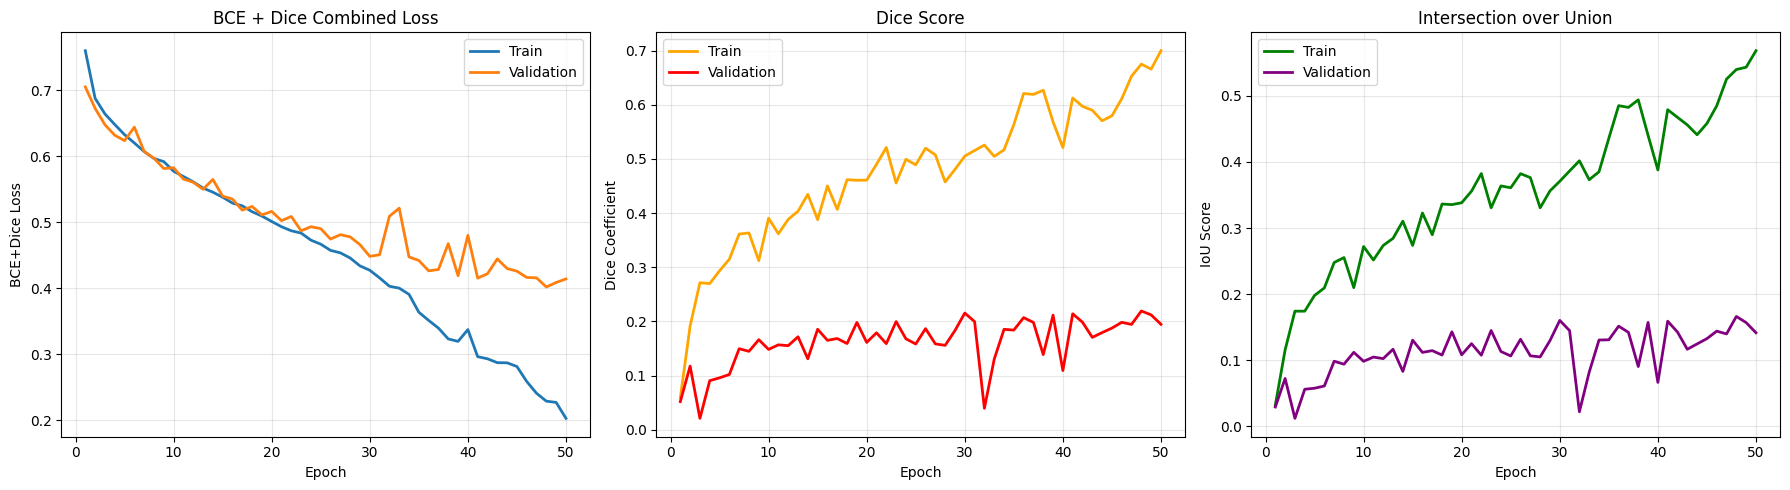

In [6]:
def plot_training_curves(history):
    """Plot training and validation curves"""
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # BCE+Dice Loss
    axes[0].plot(epochs, history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('BCE+Dice Loss')
    axes[0].set_title('BCE + Dice Combined Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Dice Score
    axes[1].plot(epochs, history['train_dice'], label='Train', linewidth=2, color='orange')
    axes[1].plot(epochs, history['val_dice'], label='Validation', linewidth=2, color='red')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Coefficient')
    axes[1].set_title('Dice Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # IoU Score
    axes[2].plot(epochs, history['train_iou'], label='Train', linewidth=2, color='green')
    axes[2].plot(epochs, history['val_iou'], label='Validation', linewidth=2, color='purple')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('IoU Score')
    axes[2].set_title('Intersection over Union')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

## 7. Classification from Segmentation Masks


🔍 EVALUATING ON TEST SET
Classification based on: Segmentation probabilities [0, 1] from sigmoid
Metrics computed: Dice & IoU for each sample



Evaluating Test: 100%|██████████| 12/12 [00:01<00:00,  7.00it/s]



=======================🎯 SEGMENTATION METRICS ========================
  Dice Coefficient: 0.6631
  IoU Score: 0.4960
  BCE+Dice Loss: 0.2099
  Pixel Accuracy: 0.9974
  Sensitivity (Recall): 0.7042
  Specificity: 0.9985
  Precision: 0.6265

===========🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ===========
  Accuracy: 0.7065
  Precision: 0.5094
  Recall: 0.9643
  F1-Score: 0.6667

  Per-Sample Metrics:
    Mean Dice: 0.1895
    Mean IoU: 0.1569

  Average Dice by Classification:
    True Positives (TP): 0.6458
    True Negatives (TN): 0.0000
    False Positives (FP): 0.0000
    False Negatives (FN): 0.0000

=========================📊 CONFUSION MATRIX ==========================


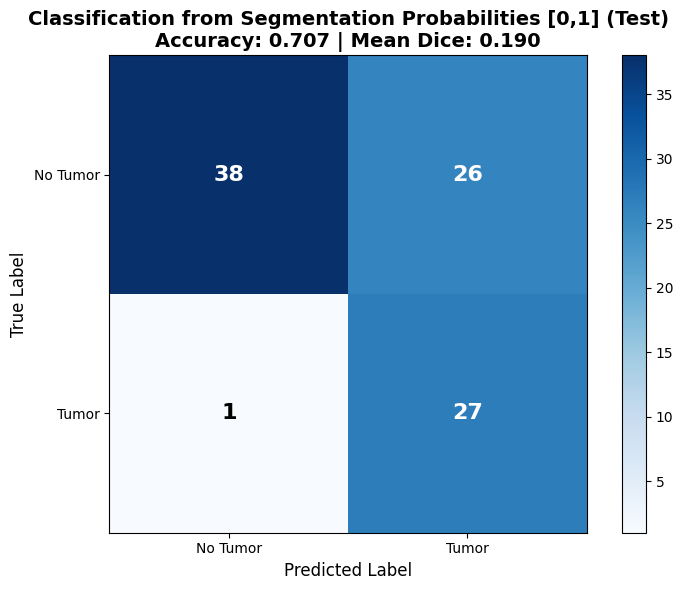

In [7]:
def classify_from_mask(mask_pred, mask_true, threshold=0.5, epsilon=1e-7):
    """
    Classify image based on segmentation probabilities [0, 1].
    
    Classification logic:
    - If ANY pixel >= threshold (0.5) in predicted mask → Tumor (1)
    - If NO pixels >= threshold → Healthy (0)
    
    Also computes Dice and IoU metrics for analysis.
    
    Args:
        mask_pred: Predicted segmentation probabilities [0, 1] (after sigmoid)
        mask_true: Ground truth mask [0, 1]
        threshold: Threshold for binarizing masks (default 0.5)
        epsilon: Small constant for numerical stability
    
    Returns:
        predicted_class: 1 if any tumor pixel detected, 0 otherwise
        dice_score: Dice coefficient for this prediction
        iou_score: IoU for this prediction
    """
    # Binarize masks at threshold 0.5
    # mask_pred already contains probabilities [0,1] from sigmoid
    # Pixels with prob ≥ 0.5 become 1, pixels < 0.5 become 0
    pred_binary = (mask_pred > threshold).float()
    true_binary = (mask_true > threshold).float()
    
    # Compute Dice coefficient
    intersection = (pred_binary * true_binary).sum().item()
    pred_sum = pred_binary.sum().item()  # Count of pixels with value 1
    true_sum = true_binary.sum().item()
    
    dice = (2.0 * intersection) / (pred_sum + true_sum + epsilon)
    
    # Compute IoU
    union = pred_sum + true_sum - intersection
    iou = intersection / (union + epsilon)
    
    # Classification: If ANY pixel == 1 (after thresholding) → Tumor
    # If ALL pixels == 0 → Healthy
    predicted_class = 1 if pred_sum > 0 else 0
    
    return predicted_class, dice, iou


def evaluate_segmentation_and_classification(model, dataloader, split_name="Test"):
    """
    Evaluate both segmentation and classification.
    Classification is derived from segmentation quality (Dice/IoU scores).
    """
    model.eval()
    
    # Segmentation metrics
    all_seg_preds = []
    all_seg_true = []
    
    # Classification metrics
    all_clf_preds = []
    all_clf_true = []
    
    # Per-sample metrics for analysis
    all_dice_scores = []
    all_iou_scores = []
    
    print("\n" + "="*70)
    print(f"🔍 EVALUATING ON {split_name.upper()} SET")
    print("="*70)
    print("Classification based on: Segmentation probabilities [0, 1] from sigmoid")
    print("Metrics computed: Dice & IoU for each sample\n")
    
    with torch.no_grad():
        for images, masks, clf_labels in tqdm(dataloader, desc=f"Evaluating {split_name}"):
            images = images.to(device)
            
            # Stage 1: Segmentation
            seg_logits = model(images)        # Raw outputs: [-∞, +∞]
            seg_probs = torch.sigmoid(seg_logits)  # Probabilities: [0, 1]
            
            # Store segmentation predictions
            all_seg_preds.append(seg_probs.cpu())
            all_seg_true.append(masks.cpu())
            
            # Stage 2: Classification from segmentation quality
            for i in range(seg_probs.size(0)):
                # Compute classification using Dice/IoU
                pred_label, dice, iou = classify_from_mask(
                    seg_probs[i].cpu(), 
                    masks[i].cpu()
                )
                true_label = clf_labels[i].item()
                
                all_clf_preds.append(pred_label)
                all_clf_true.append(true_label)
                all_dice_scores.append(dice)
                all_iou_scores.append(iou)
    
    # Concatenate segmentation results
    seg_preds = torch.cat(all_seg_preds, dim=0)
    seg_true = torch.cat(all_seg_true, dim=0)
    
    # ===============================
    # SEGMENTATION METRICS
    # ===============================
    pred_binary = (seg_preds > 0.5).float()
    true_binary = (seg_true > 0.5).float()
    
    pred_flat = pred_binary.view(-1)
    true_flat = true_binary.view(-1)
    
    TP = (pred_flat * true_flat).sum().item()
    FP = (pred_flat * (1 - true_flat)).sum().item()
    FN = ((1 - pred_flat) * true_flat).sum().item()
    TN = ((1 - pred_flat) * (1 - true_flat)).sum().item()
    
    epsilon = 1e-7
    
    iou = TP / (TP + FP + FN + epsilon)
    dice = (2 * TP) / (2 * TP + FP + FN + epsilon)
    pixel_acc = (TP + TN) / (TP + TN + FP + FN + epsilon)
    sensitivity = TP / (TP + FN + epsilon)
    specificity = TN / (TN + FP + epsilon)
    precision = TP / (TP + FP + epsilon)
    
    # Compute BCE loss
    bce_loss = seg_criterion(torch.logit(seg_preds.clamp(epsilon, 1-epsilon)), seg_true).item()
    
    seg_metrics = {
        'IoU': iou,
        'Dice': dice,
        'BCE_Dice_Loss': bce_loss,
        'Pixel_Accuracy': pixel_acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision
    }
    
    print("\n" + "🎯 SEGMENTATION METRICS ".center(70, "="))
    print(f"  Dice Coefficient: {seg_metrics['Dice']:.4f}")
    print(f"  IoU Score: {seg_metrics['IoU']:.4f}")
    print(f"  BCE+Dice Loss: {seg_metrics['BCE_Dice_Loss']:.4f}")
    print(f"  Pixel Accuracy: {seg_metrics['Pixel_Accuracy']:.4f}")
    print(f"  Sensitivity (Recall): {seg_metrics['Sensitivity']:.4f}")
    print(f"  Specificity: {seg_metrics['Specificity']:.4f}")
    print(f"  Precision: {seg_metrics['Precision']:.4f}")
    
    # ===============================
    # CLASSIFICATION METRICS
    # ===============================
    all_clf_preds = np.array(all_clf_preds)
    all_clf_true = np.array(all_clf_true)
    all_dice_scores = np.array(all_dice_scores)
    all_iou_scores = np.array(all_iou_scores)
    
    # Confusion matrix
    TP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 1))
    TN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 0))
    FP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 0))
    FN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 1))
    
    cm = np.array([[TN_clf, FP_clf], [FN_clf, TP_clf]])
    
    accuracy = (TP_clf + TN_clf) / (TP_clf + TN_clf + FP_clf + FN_clf + epsilon)
    precision_clf = TP_clf / (TP_clf + FP_clf + epsilon)
    recall_clf = TP_clf / (TP_clf + FN_clf + epsilon)
    f1_score = 2 * (precision_clf * recall_clf) / (precision_clf + recall_clf + epsilon)
    
    # Average Dice/IoU for each classification outcome
    tp_indices = (all_clf_preds == 1) & (all_clf_true == 1)
    tn_indices = (all_clf_preds == 0) & (all_clf_true == 0)
    fp_indices = (all_clf_preds == 1) & (all_clf_true == 0)
    fn_indices = (all_clf_preds == 0) & (all_clf_true == 1)
    
    avg_dice_tp = all_dice_scores[tp_indices].mean() if tp_indices.sum() > 0 else 0
    avg_dice_tn = all_dice_scores[tn_indices].mean() if tn_indices.sum() > 0 else 0
    avg_dice_fp = all_dice_scores[fp_indices].mean() if fp_indices.sum() > 0 else 0
    avg_dice_fn = all_dice_scores[fn_indices].mean() if fn_indices.sum() > 0 else 0
    
    clf_metrics = {
        'Confusion_Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision_clf,
        'Recall': recall_clf,
        'F1_Score': f1_score,
        'Avg_Dice_TP': avg_dice_tp,
        'Avg_Dice_TN': avg_dice_tn,
        'Avg_Dice_FP': avg_dice_fp,
        'Avg_Dice_FN': avg_dice_fn,
        'Mean_Dice': all_dice_scores.mean(),
        'Mean_IoU': all_iou_scores.mean()
    }
    
    print("\n" + "🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ".center(70, "="))
    print(f"  Accuracy: {clf_metrics['Accuracy']:.4f}")
    print(f"  Precision: {clf_metrics['Precision']:.4f}")
    print(f"  Recall: {clf_metrics['Recall']:.4f}")
    print(f"  F1-Score: {clf_metrics['F1_Score']:.4f}")
    print(f"\n  Per-Sample Metrics:")
    print(f"    Mean Dice: {clf_metrics['Mean_Dice']:.4f}")
    print(f"    Mean IoU: {clf_metrics['Mean_IoU']:.4f}")
    print(f"\n  Average Dice by Classification:")
    print(f"    True Positives (TP): {avg_dice_tp:.4f}")
    print(f"    True Negatives (TN): {avg_dice_tn:.4f}")
    print(f"    False Positives (FP): {avg_dice_fp:.4f}")
    print(f"    False Negatives (FN): {avg_dice_fn:.4f}")
    
    # Plot Confusion Matrix
    print("\n" + "📊 CONFUSION MATRIX ".center(70, "="))
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
    
    plt.colorbar(im, ax=ax)
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Tumor', 'Tumor'])
    ax.set_yticklabels(['No Tumor', 'Tumor'])
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, int(cm[i, j]),
                          ha="center", va="center", 
                          color="white" if cm[i, j] > cm.max()/2 else "black",
                          fontsize=16, fontweight='bold')
    
    ax.set_title(f"Classification from Segmentation Probabilities [0,1] ({split_name})\nAccuracy: {clf_metrics['Accuracy']:.3f} | Mean Dice: {clf_metrics['Mean_Dice']:.3f}", 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70 + "\n")
    
    return seg_metrics, clf_metrics


# Evaluate on Test Set
test_seg_metrics, test_clf_metrics = evaluate_segmentation_and_classification(
    unet_model, test_loader, split_name="Test"
)